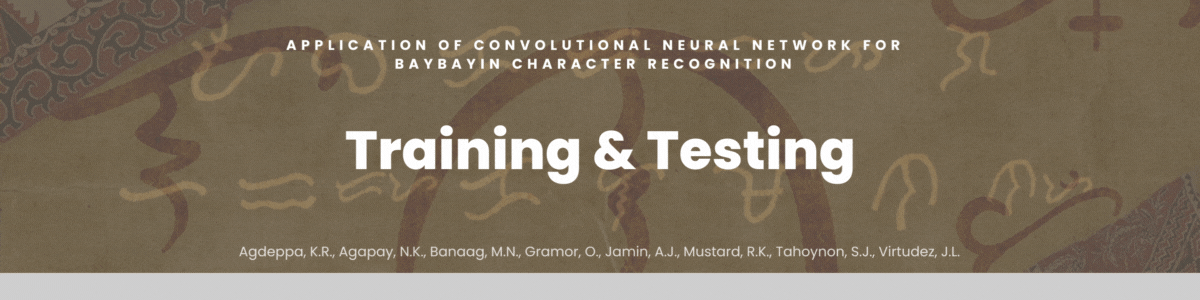

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download jamesnogra/baybayn-baybayin-handwritten-images

!unzip baybayn-baybayin-handwritten-images.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/ng.Rlp5-Nino.jpg  
  inflating: dataset/ng.SCnc-James.jpg  
  inflating: dataset/ng.T1pW-James.jpg  
  inflating: dataset/ng.T2IC-James.jpg  
  inflating: dataset/ng.TD6E-Nino.jpg  
  inflating: dataset/ng.TSUX-James.jpg  
  inflating: dataset/ng.TUXx-James.jpg  
  inflating: dataset/ng.Tdg3-James.jpg  
  inflating: dataset/ng.TfDv-John.jpg  
  inflating: dataset/ng.Th2r-Nino.jpg  
  inflating: dataset/ng.TliN-James.jpg  
  inflating: dataset/ng.U2bd-James.jpg  
  inflating: dataset/ng.UNG0-John.jpg  
  inflating: dataset/ng.UYe8-John.jpg  
  inflating: dataset/ng.Uvdi-Nino.jpg  
  inflating: dataset/ng.V0kZ-James.jpg  
  inflating: dataset/ng.V6Wn-Nino.jpg  
  inflating: dataset/ng.VJa6-John.jpg  
  inflating: dataset/ng.VfIc-James.jpg  
  inflating: dataset/ng.Vt1J-James.jpg  
  inflating: dataset/ng.VurW-James.jpg  
  inflating: dataset/ng.VxbK-James.jpg  
  inflating: dataset/ng.X9g9-Nino.jpg  
  inflating: dat

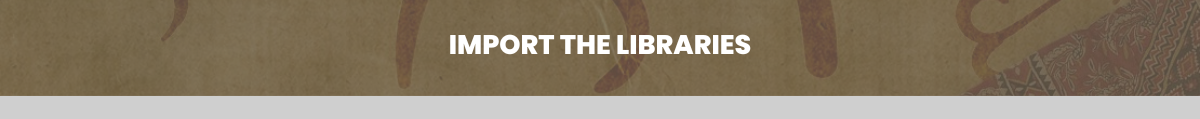

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from joblib import dump

import warnings
warnings.filterwarnings("ignore")

In [3]:
# set the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

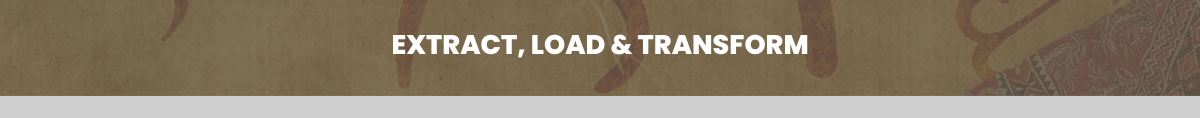

In [4]:
# extracting the image path and their corresponding labels
IMAGE_FILES_LIST = []
IMAGE_LABELS_LIST = []

for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        IMAGE_LABELS_LIST.append(filename.split(".")[0])
        IMAGE_FILES_LIST.append(os.path.join(dirname, filename))

In [5]:
class ImageDataset(Dataset):
    """
        Loads all the images, converts it to grayscale and transforms it into tensor.

        Attributes
        ----------
        image_files: list or tuple
            a list of strings that contains the path to the images

        image_labels: list or tuple
            a list of strings that contains the labels relative to the images

        transform: function, default = None
            A transform to apply to the images.
    """
    def __init__(self, image_files, image_labels, transform=None):

        self.image_labels = image_labels
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        """
            Returns the number of images in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
            Returns the image and any associated label (if applicable) at the specified index.
        """

        image_path = self.image_files[idx]
        image_label = self.image_labels[idx]

        image = Image.open(image_path).convert('L')

        if self.transform:
            X = self.transform(image)

        return (X, image_label)

In [6]:

UNIQUE_LABELS_ARR = np.unique(IMAGE_LABELS_LIST)

LABELS_MAPPING_REFERENCE = {label:idx for idx, label in enumerate(UNIQUE_LABELS_ARR)}

TRANSFORMED_LABELS_LIST = [LABELS_MAPPING_REFERENCE[labels] for labels in IMAGE_LABELS_LIST]

In [7]:
UNIQUE_LABELS_ARR = np.unique(IMAGE_LABELS_LIST)

LABELS_MAPPING_REFERENCE = {label:idx for idx, label in enumerate(UNIQUE_LABELS_ARR)}

TRANSFORMED_LABELS_LIST = [LABELS_MAPPING_REFERENCE[labels] for labels in IMAGE_LABELS_LIST]

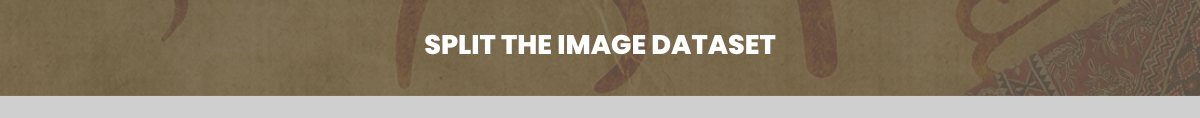

In [8]:
# transformation
TRANSFORM = transforms.Compose([transforms.ToTensor()])

IMAGE_DATASET = ImageDataset(image_files=IMAGE_FILES_LIST,
                            image_labels=TRANSFORMED_LABELS_LIST,
                            transform=TRANSFORM)

# 0,6/0,2/0.2 SPLIT RATIO
train_set, _, test_set = torch.utils.data.random_split(IMAGE_DATASET, [0.6, 0.2, 0.2])

In [9]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
class ConvolutionalNeuralNetwork(nn.Module):
    """
        Convolutional Neural Network (CNN) for image classification.

        Parameters
        ----------
        conv_filter_size : tuple
            The size of the convolution filter.
        activation_function : function
            The activation function to be applied after each convolutional layer.
        final_size : int
            The final size of the image after the 3 convolutions and maxpooling

        Attributes
        ----------
        conv1 : nn.Conv2d
            First convolutional layer with 32 output channels.
        pool1 : nn.MaxPool2d
            First max-pooling layer.
        conv2 : nn.Conv2d
            Second convolutional layer with 64 output channels.
        pool2 : nn.MaxPool2d
            Second max-pooling layer.
        conv3 : nn.Conv2d
            Third convolutional layer with 128 output channels.
        pool3 : nn.MaxPool2d
            Third max-pooling layer.
        fcn1 : nn.Linear
            First fully connected layer with 512 output features.
        fcn2 : nn.Linear
            Second fully connected layer with 63 output features.

        Methods
        -------
        forward(x)
            Forward pass through the CNN.

        Examples
        --------
        >>> import torch
        >>> import torch.nn as nn
        >>> import torch.nn.functional as F
        >>>
        >>> # Create an instance of ConvolutionalNeuralNetwork
        >>> cnn = ConvolutionalNeuralNetwork((3, 3), F.relu, 8)
        >>>
        >>> # Perform a forward pass with dummy input
        >>> input_data = torch.randn(1, 1, 28, 28)  # (batch size, channels, height, width)
        >>> output = cnn(input_data)
    """

    def __init__(self, conv_filter_size, activation_function, final_size):
        super().__init__()

        self.conv_filter_size = conv_filter_size
        self.activation_function = activation_function
        self.final_size = final_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=self.conv_filter_size,
                               stride=1,
                               padding=0)

        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2),
                                  stride=1)

        # Fully connected layers
        self.fcn1 = nn.Linear(128 * self.final_size * self.final_size, 512)
        self.fcn2 = nn.Linear(512, 63)

    def forward(self, x):
        x = self.activation_function(self.conv1(x))
        x = self.pool1(x)

        x = self.activation_function(self.conv2(x))
        x = self.pool2(x)

        x = self.activation_function(self.conv3(x))
        x = self.pool3(x)

        x = x.view(-1, 128 * self.final_size * self.final_size)

        x = self.activation_function(self.fcn1(x))

        x = F.softmax(self.fcn2(x), dim=1)

        return x

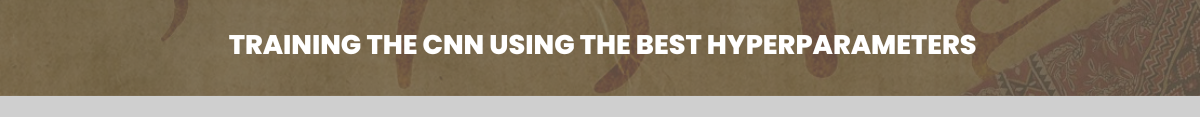

In [12]:
original_size = 28
_PADDING = 0
_STRIDE = 1
_MAX_POOL_SIZE = 2
_NUM_OF_CONV = 3
_KERNEL_SIZE = 7

# calculate the new size after 3 convolutions with 7x7 kernel size, 0 stride with 1 padding
for _ in range(_NUM_OF_CONV):
    original_size = (original_size - _KERNEL_SIZE + 2 * _PADDING) // _STRIDE + 1
    original_size = (original_size - _MAX_POOL_SIZE) // _STRIDE + 1

# optimal hyperparameters
learning_rate = 0.00022470591373363572
epochs = 47
kernel_size = (7, 7)
opt_activation_function = F.tanh

CNN_MODEL = ConvolutionalNeuralNetwork(conv_filter_size = kernel_size,
                                       activation_function = opt_activation_function,
                                       final_size = original_size)

optimizer = optim.Adam(CNN_MODEL.parameters(), lr=learning_rate)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []

CNN_MODEL = CNN_MODEL.to("cuda")

# Training loop
for epoch in range(epochs):
    CNN_MODEL.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = CNN_MODEL(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        # The total and correct predictions
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate the average loss for each epoch
    epoch_loss = running_loss / len(train_loader)
    # Calculate the training accuracy for each epoch
    epoch_accuracy = correct_predictions / total_predictions

    # Append the epoch loss and accuracy to the lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print the loss and accuracy for each epoch
    print(f"Epoch {epoch+1} - Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

Epoch 1 - Loss: 4.036829988376514, Accuracy: 0.14372778059928898
Epoch 2 - Loss: 3.884958268500663, Accuracy: 0.31030980192991364
Epoch 3 - Loss: 3.794195542464385, Accuracy: 0.4017267648552565
Epoch 4 - Loss: 3.735430851498166, Accuracy: 0.462671406805485
Epoch 5 - Loss: 3.688648029275843, Accuracy: 0.5114271203656678
Epoch 6 - Loss: 3.650907311568389, Accuracy: 0.5463009988149653
Epoch 7 - Loss: 3.6238817627365525, Accuracy: 0.5711867276113086
Epoch 8 - Loss: 3.603814345437127, Accuracy: 0.5874386321313696
Epoch 9 - Loss: 3.5819372022474134, Accuracy: 0.6101235821906213
Epoch 10 - Loss: 3.5580188905870593, Accuracy: 0.6346707296427967
Epoch 11 - Loss: 3.5337617113783555, Accuracy: 0.6651430506179109
Epoch 12 - Loss: 3.503389665242788, Accuracy: 0.6939224648721856
Epoch 13 - Loss: 3.473592724671235, Accuracy: 0.7264262739123074
Epoch 14 - Loss: 3.449443397006473, Accuracy: 0.7464025732182157
Epoch 15 - Loss: 3.431606755385528, Accuracy: 0.7621466057220248
Epoch 16 - Loss: 3.4171804763

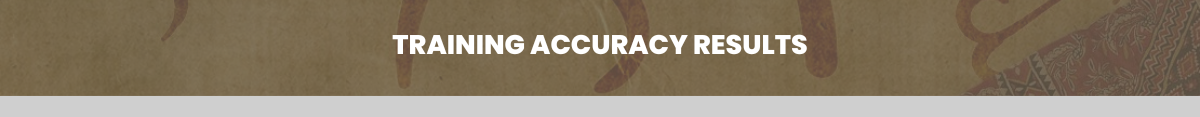

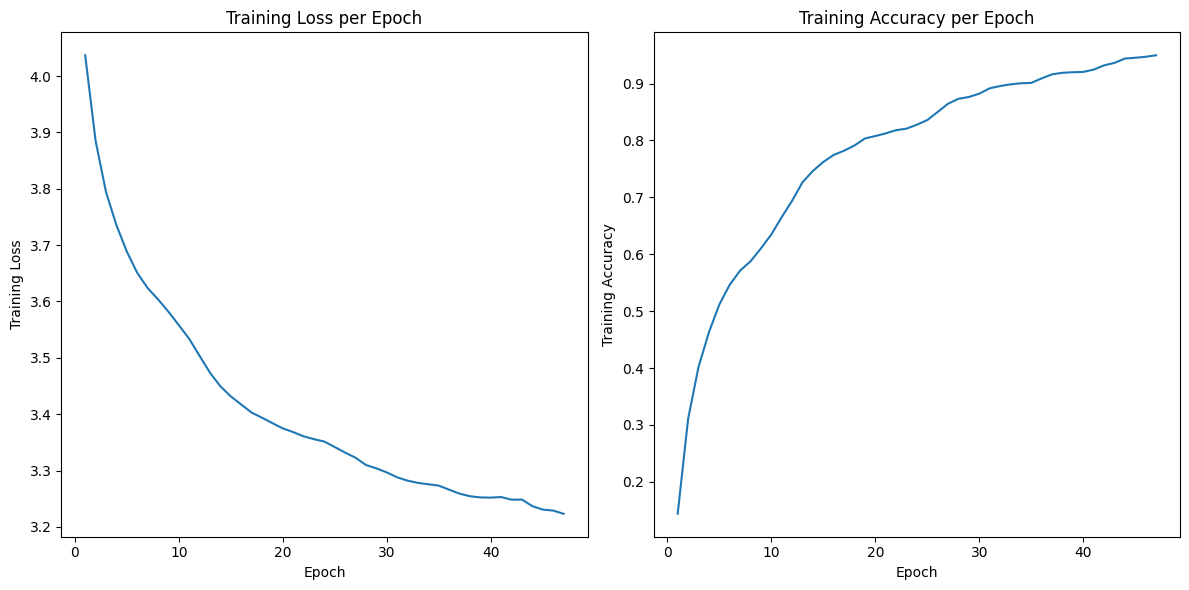

In [15]:
# Set the figure size
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


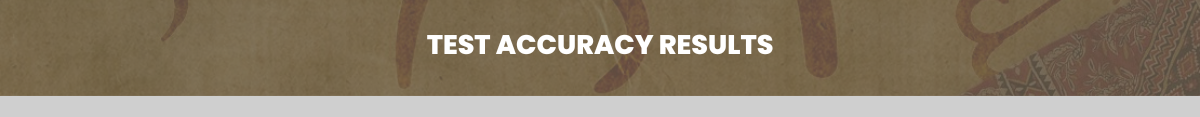

In [20]:
true_labels = []
pred_labels = []

CNN_MODEL.eval()
with torch.no_grad():
    for b, (x_test, y_test) in enumerate(test_loader):
        x_test = x_test.to("cuda")
        y_test = y_test.to("cuda")

        test_pred = CNN_MODEL(x_test)
        test_pred_vec = torch.max(test_pred.data, 1)[1]

        true_labels.append(y_test)
        pred_labels.append(test_pred_vec)

In [21]:
true_labels = torch.cat(true_labels, dim=0).to("cpu")
pred_labels = torch.cat(pred_labels, dim=0).to("cpu")

In [30]:
# Convert PyTorch tensors to NumPy arrays
true_labels_np = true_labels.cpu().numpy()
pred_labels_np = pred_labels.cpu().numpy()

# Calculate accuracy using sklearn's accuracy_score
accuracy = accuracy_score(true_labels_np, pred_labels_np)

In [32]:
print(f"Overall test accuracy: {accuracy}")

Overall test accuracy: 0.8552564753682073


In [22]:
# Convert true_labels and pred_labels to NumPy arrays
true_labels_np = true_labels.numpy()
pred_labels_np = pred_labels.numpy()

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels_np, pred_labels_np)

# Calculate accuracy for each class
class_accuracies = confusion_mat.diagonal() / confusion_mat.sum(axis=1)

# Print the accuracy for each class
for i, accuracy in enumerate(class_accuracies):
    print(f'Class {i}: Accuracy = {accuracy:.2f}')


Class 0: Accuracy = 0.87
Class 1: Accuracy = 0.79
Class 2: Accuracy = 0.96
Class 3: Accuracy = 0.93
Class 4: Accuracy = 0.80
Class 5: Accuracy = 0.84
Class 6: Accuracy = 1.00
Class 7: Accuracy = 0.97
Class 8: Accuracy = 0.96
Class 9: Accuracy = 1.00
Class 10: Accuracy = 0.79
Class 11: Accuracy = 0.93
Class 12: Accuracy = 0.78
Class 13: Accuracy = 0.92
Class 14: Accuracy = 0.98
Class 15: Accuracy = 1.00
Class 16: Accuracy = 1.00
Class 17: Accuracy = 0.94
Class 18: Accuracy = 0.00
Class 19: Accuracy = 1.00
Class 20: Accuracy = 1.00
Class 21: Accuracy = 1.00
Class 22: Accuracy = 0.97
Class 23: Accuracy = 0.94
Class 24: Accuracy = 0.90
Class 25: Accuracy = 0.85
Class 26: Accuracy = 0.90
Class 27: Accuracy = 0.96
Class 28: Accuracy = 1.00
Class 29: Accuracy = 0.94
Class 30: Accuracy = 0.82
Class 31: Accuracy = 0.95
Class 32: Accuracy = 0.85
Class 33: Accuracy = 0.92
Class 34: Accuracy = 0.94
Class 35: Accuracy = 0.94
Class 36: Accuracy = 0.90
Class 37: Accuracy = 0.74
Class 38: Accuracy = 0

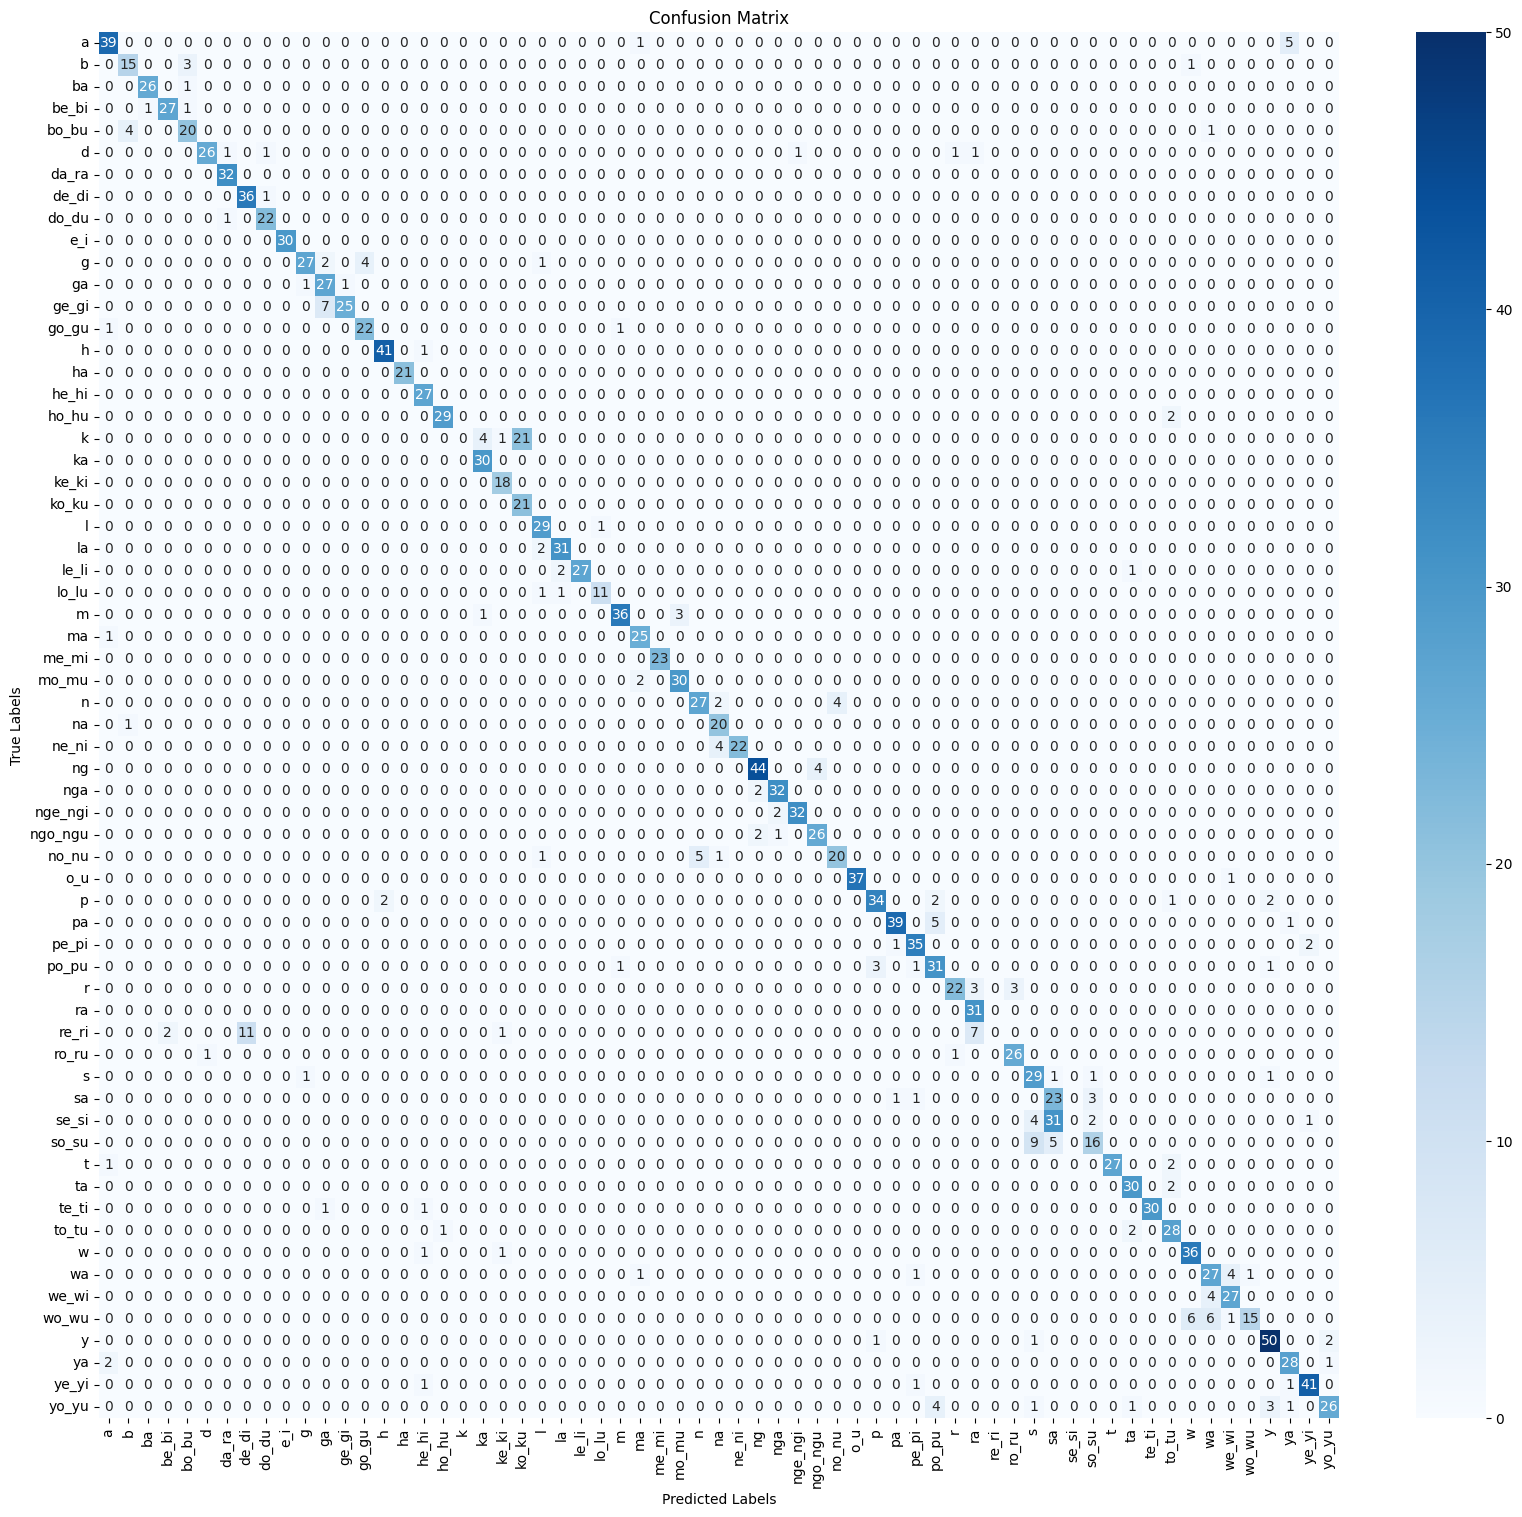

In [26]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS_MAPPING_REFERENCE, yticklabels=LABELS_MAPPING_REFERENCE)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the plot as an image (e.g., PNG format)
#plt.savefig('confusion_matrix.png')

# Show the plot
plt.show()

In [24]:
misses = np.array([])
missed_label = np.array([])

for i in range(len(pred_labels)):
    if pred_labels[i] != true_labels[i]:
        misses = np.append(misses, i).astype('int64')
        missed_label = np.append(missed_label, true_labels[i]).astype('int64')

len(misses)

285

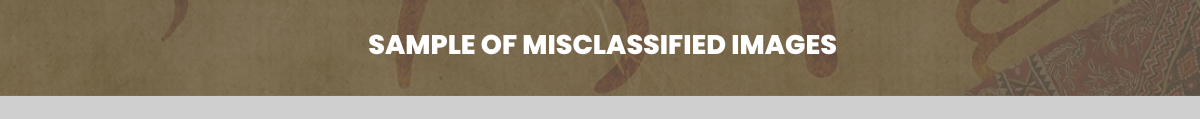

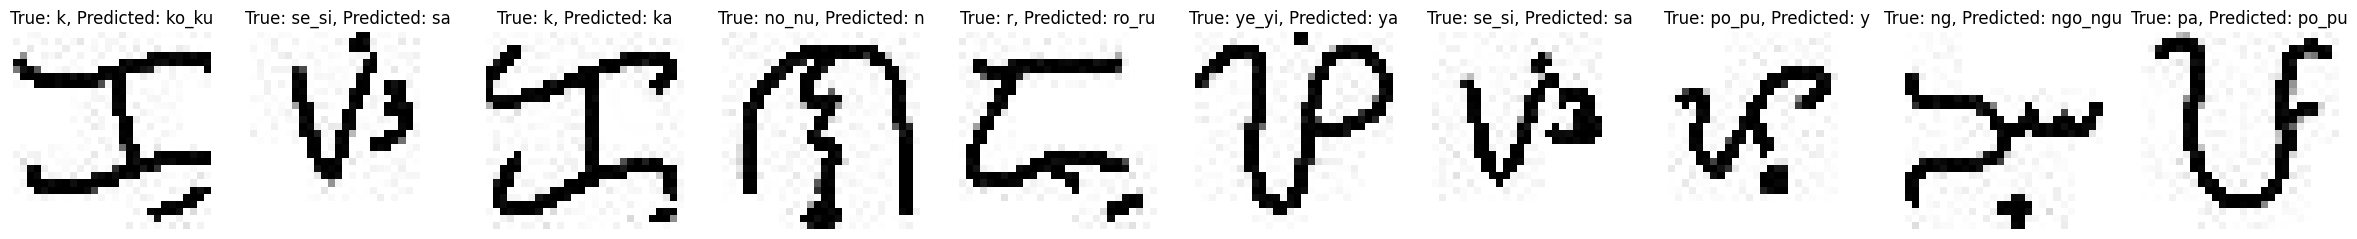

In [28]:
# Get the first 10 misclassified samples
missed_indices = misses[:10]
missed_true_labels = [number_label[label.item()] for label in true_labels[missed_indices]]
missed_pred_labels = [number_label[label.item()] for label in pred_labels[missed_indices]]

# Retrieve and plot the misclassified images
fig, axs = plt.subplots(1, len(missed_indices), figsize=(30, 15))
for i, index in enumerate(missed_indices):
    img, _ = test_loader.dataset[index]
    axs[i].imshow(img[0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True: {missed_true_labels[i]}, Predicted: {missed_pred_labels[i]}")
plt.show()
